# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# create the model

in this project we will try to solve the probelm with DDPG network, so wee need to difine 2 networks the actor and the critic networks

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np



def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class actor_network(nn.Module):
    def __init__(self,state_size = 24, action_size =2 ,seed = 0):
        super(actor_network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size,120)
        self.fc2 = nn.Linear(120,128)   
        self.fc3 = nn.Linear(128,130)   
        self.output = nn.Linear(130,action_size)
        self.reset_parameters()
        
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = state
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        
        
        return F.tanh(self.output(x))

In [8]:
class critic_network(nn.Module):
    def __init__(self,state_size = 24,action_size = 2 ,seed = 0):
        super(critic_network, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size,120)
        self.fc2 = nn.Linear(120 + action_size,128)
        self.fc3 = nn.Linear(128,130)
        self.output = nn.Linear(130,1)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.output.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, actions):
        x = F.leaky_relu(self.fc1(state))
        x = torch.cat((x,actions),dim = 1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.output(x)

In [9]:
class ReplayBuffer:
    

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [11]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-5         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
TAU = 1e-3              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agents():
 
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.steps = 0

        # Actor Network (w/ Target Network)
        self.actor_local = actor_network(state_size, action_size, random_seed).to(device)
        self.actor_target = actor_network(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = critic_network(state_size, action_size, random_seed).to(device)
        self.critic_target = critic_network(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        
       
        
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
   
            
    def step(self, state, action, reward, next_state, done):
        # Save experiences one by one in the memory before the learning operation
        for i in range(self.num_agents):
            self.memory.add(state[i,:], action[i,:], reward[i], next_state[i,:], done[i])

        self.steps +=1
        if self.steps % LEARN_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                for _ in range(3):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
      
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # clip the grad to avoid its explosing
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # clip the grad to avoid its explosing
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
          
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            

# tring the network

In [17]:
agent = Agents(state_size=24, action_size=2,num_agents=2, random_seed=0)



def train_DDPG(agent,episodes=2000,number_agents = 2,max_t = 1000):
    best_mean_score = -100
    scores_array = []
    mean_scores = []
    max_scores = []
    min_scores = []
    scores_window = deque(maxlen = 100)
   
    
    for episode in range(1,episodes+1):
        states = env.reset(train_mode = True)[brain_name].vector_observations
        scores = np.zeros(number_agents)
        agent.reset()
        for i in range(max_t):
            actions = agent.act(states,add_noise = True)
            step_info = env.step(actions)[brain_name]
            next_states = step_info.vector_observations
            rewards = step_info.rewards
            dones = step_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        
        mean_scores.append(np.mean(scores))
        max_scores.append(np.max(scores))
        min_scores.append(np.min(scores))
        scores_window.append(mean_scores[-1])
        scores_array.append(scores)
        
        print('\rEpisode {}\t Average Score: {:.2f}\t max score: {:.2f}\t min score: {:.2f}'.format(episode,np.mean(scores_window),max_scores[-1],min_scores[-1]), end="")
        if episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
        
        if np.mean(scores_window)> best_mean_score:
            best_mean_score = np.mean(scores_window)
            print('\nEnvironment saved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor_local_checkpointV2.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_local_checkpointV2.pth')
            
            
    return scores_window,scores_array,mean_scores

In [18]:
scores_window, scores_array ,mean_scores= train_DDPG(agent,episodes = 2000)

Episode 1	 Average Score: -0.00	 max score: 0.00	 min score: -0.01
Environment saved in 1 episodes!	Average Score: -0.00
Episode 8	 Average Score: 0.00	 max score: 0.10	 min score: -0.011
Environment saved in 8 episodes!	Average Score: 0.00
Episode 50	Average Score: -0.000	 max score: 0.00	 min score: -0.01
Episode 100	Average Score: -0.000	 max score: 0.00	 min score: -0.01
Episode 150	Average Score: -0.000	 max score: 0.00	 min score: -0.01
Episode 200	Average Score: -0.000	 max score: 0.00	 min score: -0.01
Episode 250	Average Score: -0.000	 max score: 0.00	 min score: -0.01
Episode 292	 Average Score: 0.00	 max score: 0.10	 min score: 0.0911
Environment saved in 292 episodes!	Average Score: 0.00
Episode 293	 Average Score: 0.00	 max score: 0.10	 min score: -0.01
Environment saved in 293 episodes!	Average Score: 0.00
Episode 297	 Average Score: 0.00	 max score: 0.10	 min score: -0.01
Environment saved in 297 episodes!	Average Score: 0.00
Episode 300	Average Score: 0.000	 max score: 

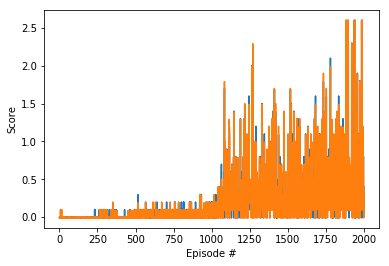

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_array)), scores_array)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()